<a href="https://colab.research.google.com/github/SKashhh/Voyage-AI-Traveller-Segmentation/blob/main/VOYAGE_AI_TRAVELLER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Voyage AI – Traveller Segmentation

#This notebook implements an unsupervised machine learning approach to segment travellers based on their travel behaviour.


In [25]:
## Problem Statement: Voyage AI aims to understand traveller behaviour in order to enable personalized recommendations and targeted marketing.

## Objective: To discover natural traveller segments using K-Means clustering.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Set plotting style
sns.set_style("whitegrid")

print("="*70)
print("VOYAGE AI - TRAVEL ANALYTICS CLUSTERING PROJECT")
print("CSE Sophomore ML Project")
print("="*70)

VOYAGE AI - TRAVEL ANALYTICS CLUSTERING PROJECT
CSE Sophomore ML Project


In [28]:
# 2. DATA GENERATION (Simulated Travel Data)
print("\n[STEP 1] Generating synthetic travel data...")

np.random.seed(42)
n_samples = 1000

# Generate features with natural correlations and variations
# NO pre-designed segments - let K-Means discover patterns naturally!

# Trip frequency: 1-15 trips per year (continuous distribution)
trip_frequency = np.random.gamma(shape=2, scale=2, size=n_samples)
trip_frequency = np.clip(trip_frequency, 1, 15)

# Booking value: $200-$5000 (log-normal distribution for realistic spending)
avg_booking_value = np.random.lognormal(mean=6.5, sigma=0.8, size=n_samples)
avg_booking_value = np.clip(avg_booking_value, 200, 5000)

# Destination diversity: Related to trip frequency (more trips = more destinations)
# Add some randomness so it's not perfectly correlated
destination_diversity = (trip_frequency * 0.7 + np.random.normal(0, 1.5, n_samples))
destination_diversity = np.clip(destination_diversity, 1, 10).astype(int)

# Session duration: Inversely related to trip frequency (frequent travelers decide faster)
# But also positively related to booking value (expensive trips need more research)
session_duration_mins = (15 - trip_frequency * 0.5 +
                         avg_booking_value * 0.003 +
                         np.random.normal(0, 3, n_samples))
session_duration_mins = np.clip(session_duration_mins, 5, 45)

# Searches per session: Related to session duration and booking value
searches_per_session = (session_duration_mins * 0.6 +
                        avg_booking_value * 0.002 +
                        np.random.normal(0, 2, n_samples))
searches_per_session = np.clip(searches_per_session, 3, 25)

# Create dataframe
df = pd.DataFrame({
    'trip_frequency': trip_frequency,
    'avg_booking_value': avg_booking_value,
    'destination_diversity': destination_diversity,
    'session_duration_mins': session_duration_mins,
    'searches_per_session': searches_per_session
})

# Add some missing values randomly (2%)
missing_indices = np.random.choice(df.index, size=int(n_samples * 0.02), replace=False)
df.loc[missing_indices, 'session_duration_mins'] = np.nan

# Add user IDs
df.insert(0, 'user_id', [f'USER_{i:04d}' for i in range(1, n_samples + 1)])

print(f"✓ Dataset generated: {len(df)} records")
print(f"✓ Features have natural correlations - NO pre-designed clusters")
print(f"✓ K-Means will discover patterns from the data itself")
print(f"✓ Features: {list(df.columns[1:])}")


[STEP 1] Generating synthetic travel data...
✓ Dataset generated: 1000 records
✓ Features have natural correlations - NO pre-designed clusters
✓ K-Means will discover patterns from the data itself
✓ Features: ['trip_frequency', 'avg_booking_value', 'destination_diversity', 'session_duration_mins', 'searches_per_session']


In [29]:
import os

OUTPUT_DIR = "/mnt/user-data/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)



[STEP 2] Exploratory Data Analysis...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                1000 non-null   object 
 1   trip_frequency         1000 non-null   float64
 2   avg_booking_value      1000 non-null   float64
 3   destination_diversity  1000 non-null   int64  
 4   session_duration_mins  980 non-null    float64
 5   searches_per_session   1000 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB
None

Statistical Summary:
       trip_frequency  avg_booking_value  destination_diversity  \
count     1000.000000        1000.000000              1000.0000   
mean         4.144823         900.670206                 2.7600   
std          2.768980         759.611761                 2.0036   
min          1.000000         200.000000                 1.0000   


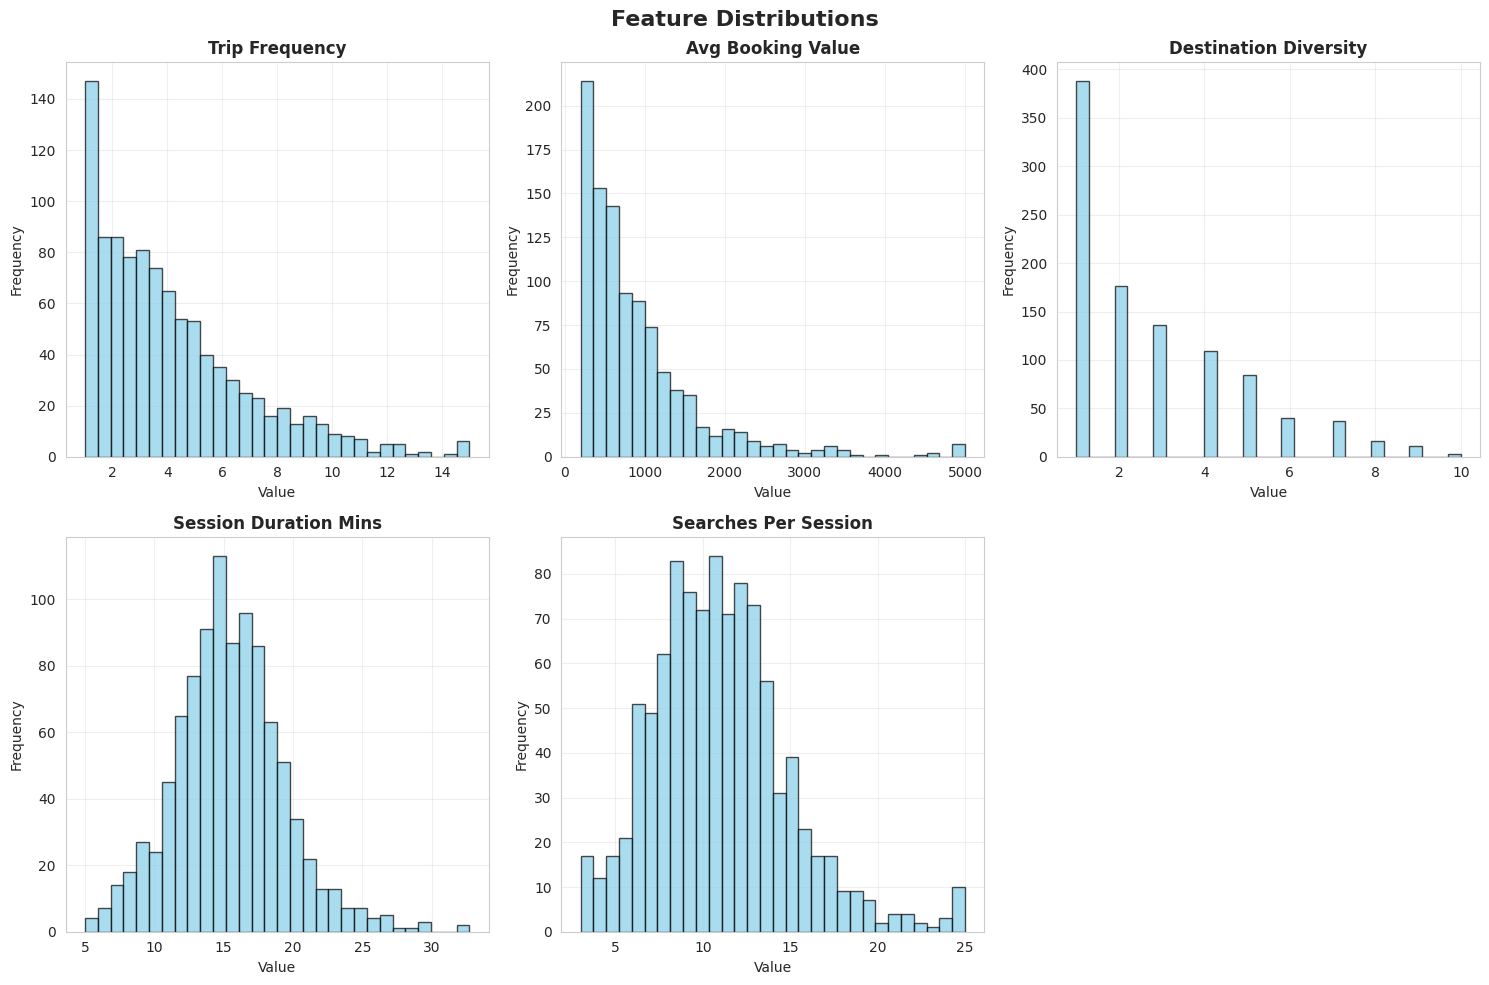

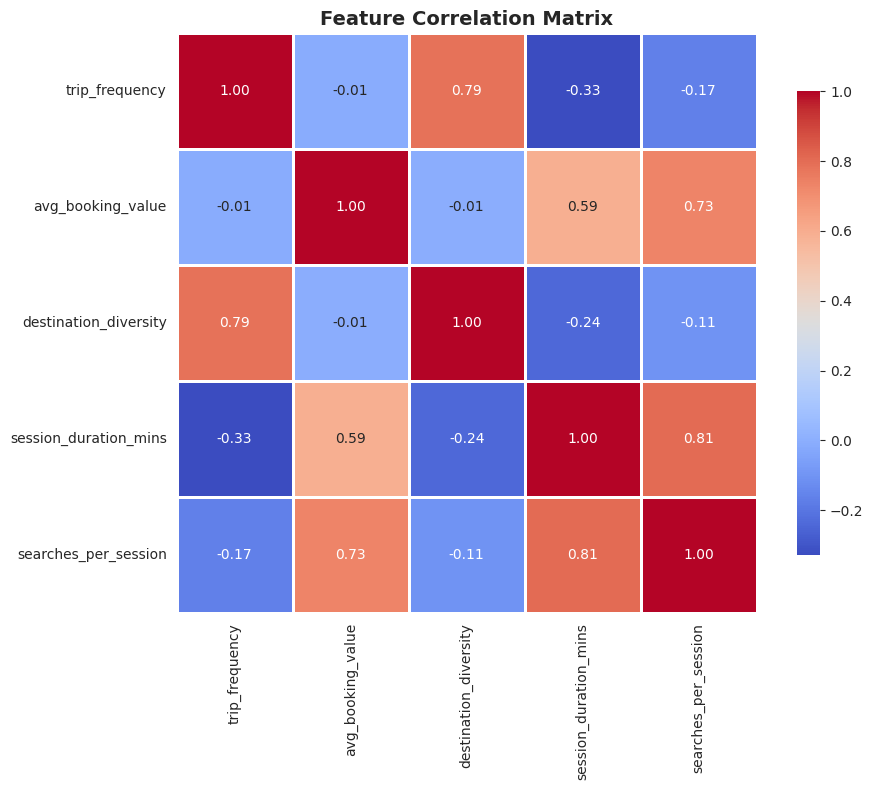

In [30]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
print("\n[STEP 2] Exploratory Data Analysis...")

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# Feature list
features = ['trip_frequency', 'avg_booking_value', 'destination_diversity',
            'session_duration_mins', 'searches_per_session']

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    axes[row, col].hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[row, col].set_title(feature.replace('_', ' ').title(), fontweight='bold')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/01_feature_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_feature_distributions.png")

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/02_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 02_correlation_matrix.png")

In [31]:
# 4. DATA CLEANING AND PREPROCESSING
print("\n[STEP 3] Data Cleaning and Preprocessing...")

df_clean = df.copy()

# Handle missing values - fill with median (simple approach)
for feature in features:
    if df_clean[feature].isnull().sum() > 0:
        median_value = df_clean[feature].median()
        df_clean[feature].fillna(median_value, inplace=True)

print(f"✓ Missing values handled using median imputation")
print(f"  Remaining missing values: {df_clean[features].isnull().sum().sum()}")
print(f"\n✓ Clean dataset shape: {df_clean.shape}")


[STEP 3] Data Cleaning and Preprocessing...
✓ Missing values handled using median imputation
  Remaining missing values: 0

✓ Clean dataset shape: (1000, 6)



[STEP 4] Feature Scaling...
✓ Features scaled using StandardScaler

Scaled Features Summary:
       trip_frequency  avg_booking_value  destination_diversity  \
count    1.000000e+03       1.000000e+03           1.000000e+03   
mean     3.907985e-17       1.385558e-16           1.136868e-16   
std      1.000500e+00       1.000500e+00           1.000500e+00   
min     -1.136302e+00      -9.228672e-01          -8.788582e-01   
25%     -7.560356e-01      -6.623856e-01          -8.788582e-01   
50%     -2.481198e-01      -3.027071e-01          -3.795070e-01   
75%      4.839914e-01       3.062941e-01           6.191956e-01   
max      3.922242e+00       5.399312e+00           3.615303e+00   

       session_duration_mins  searches_per_session  
count           1.000000e+03          1.000000e+03  
mean            1.474376e-16         -2.486900e-17  
std             1.000500e+00          1.000500e+00  
min            -2.659866e+00         -2.046773e+00  
25%            -6.213308e-01         

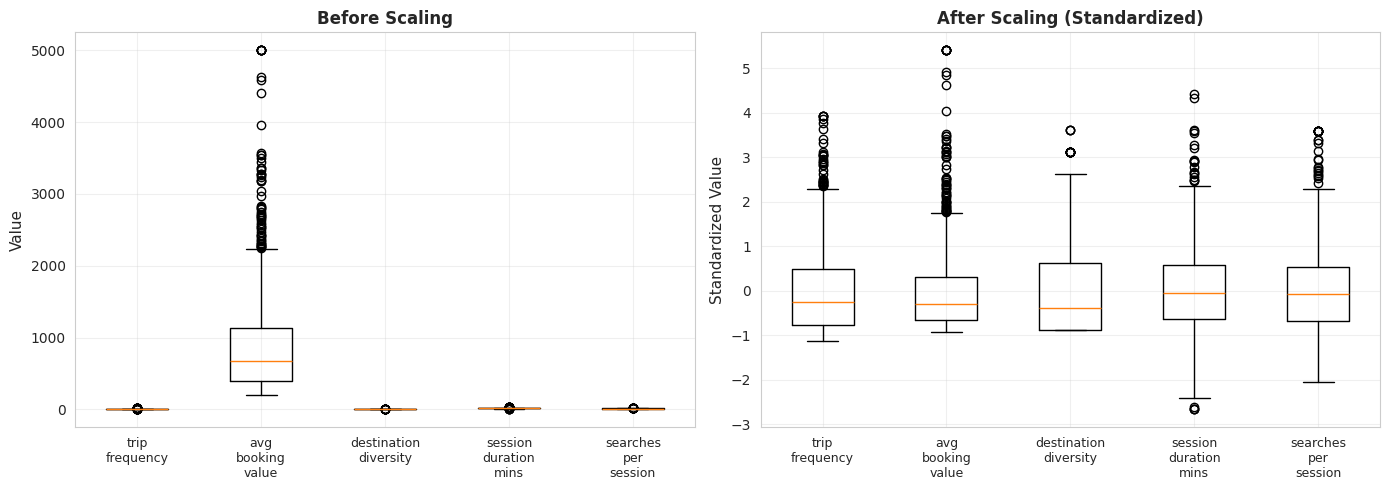

In [32]:
# 5. FEATURE SCALING
print("\n[STEP 4] Feature Scaling...")

X = df_clean[features].values

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)

print("✓ Features scaled using StandardScaler")
print("\nScaled Features Summary:")
print(df_scaled.describe())

# Visualize scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bp1 = axes[0].boxplot([df_clean[feat] for feat in features], labels=[f.replace('_', '\n') for f in features])
axes[0].set_title('Before Scaling', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Value', fontsize=11)
axes[0].tick_params(axis='x', rotation=0, labelsize=9)
axes[0].grid(True, alpha=0.3)

bp2 = axes[1].boxplot([df_scaled[feat] for feat in features], labels=[f.replace('_', '\n') for f in features])
axes[1].set_title('After Scaling (Standardized)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Standardized Value', fontsize=11)
axes[1].tick_params(axis='x', rotation=0, labelsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/03_feature_scaling.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_feature_scaling.png")


[STEP 5] Determining Optimal Number of Clusters...
  Running Elbow Method...
✓ Saved: 04_elbow_method.png
  Running Silhouette Analysis...
✓ Saved: 05_silhouette_analysis.png

✓ Optimal k based on Silhouette Score: 3
  Best Silhouette Score: 0.3386


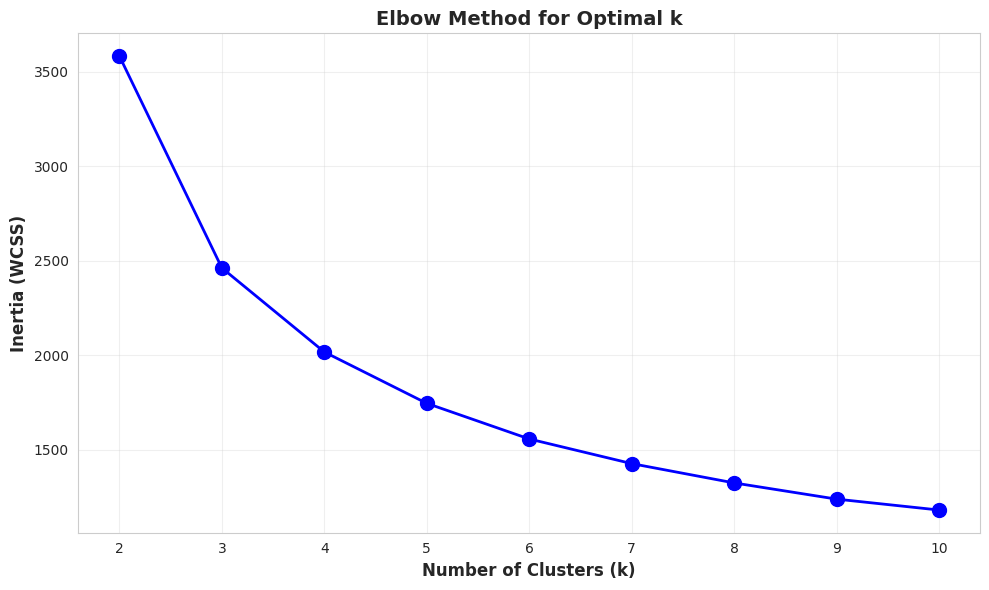

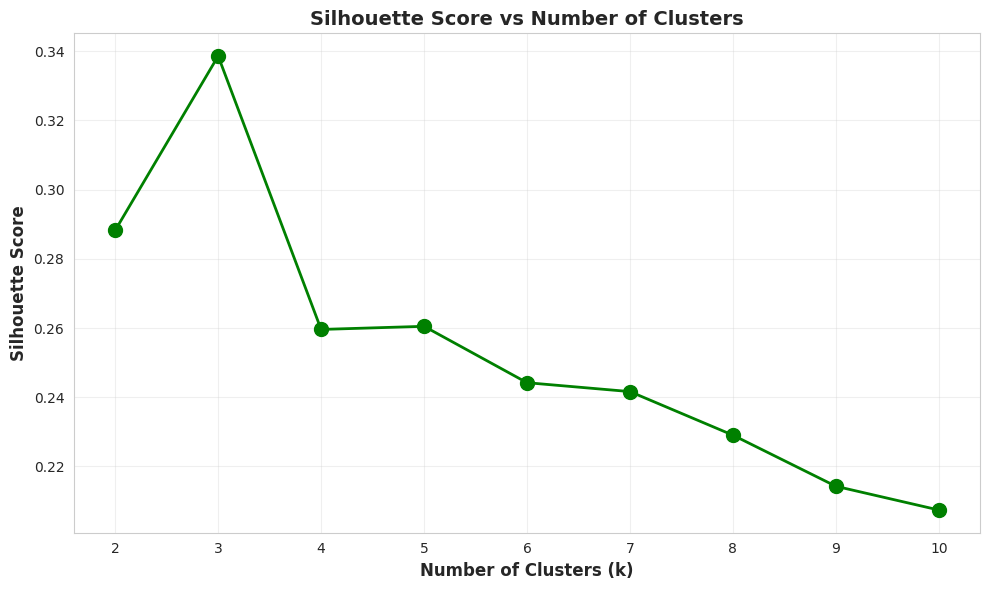

In [33]:
# 6. OPTIMAL NUMBER OF CLUSTERS
print("\n[STEP 5] Determining Optimal Number of Clusters...")

K_range = range(2, 11)

# Elbow Method
print("  Running Elbow Method...")
inertias = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Inertia (WCSS)', fontsize=12, fontweight='bold')
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/04_elbow_method.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_elbow_method.png")

# Silhouette Analysis
print("  Running Silhouette Analysis...")
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/05_silhouette_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_silhouette_analysis.png")

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal k based on Silhouette Score: {optimal_k}")
print(f"  Best Silhouette Score: {max(silhouette_scores):.4f}")

In [34]:
# 7. K-MEANS CLUSTERING
print("\n[STEP 6] Applying K-Means Clustering...")

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
df_clean['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# Evaluate clustering quality using Silhouette Score
silhouette_kmeans = silhouette_score(X_scaled, df_clean['cluster_kmeans'])

print(f"✓ K-Means clustering completed with k={optimal_k}")
print(f"\nClustering Quality Metric:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  (Range: -1 to 1, where higher values indicate better-defined clusters)")
print(f"  Score interpretation: {'Excellent' if silhouette_kmeans > 0.7 else 'Good' if silhouette_kmeans > 0.5 else 'Reasonable' if silhouette_kmeans > 0.25 else 'Weak'} clustering")

# Cluster distribution
print(f"\nCluster Distribution:")
cluster_counts = df_clean['cluster_kmeans'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} users ({count/len(df_clean)*100:.1f}%)")


[STEP 6] Applying K-Means Clustering...
✓ K-Means clustering completed with k=4

Clustering Quality Metric:
  Silhouette Score: 0.2596
  (Range: -1 to 1, where higher values indicate better-defined clusters)
  Score interpretation: Reasonable clustering

Cluster Distribution:
  Cluster 0: 73 users (7.3%)
  Cluster 1: 393 users (39.3%)
  Cluster 2: 194 users (19.4%)
  Cluster 3: 340 users (34.0%)



[STEP 7] Visualizing Clusters using PCA...
✓ PCA completed
  PC1 explains 51.5% variance
  PC2 explains 33.5% variance
  Total variance explained: 84.9%
✓ Saved: 06_cluster_visualization.png


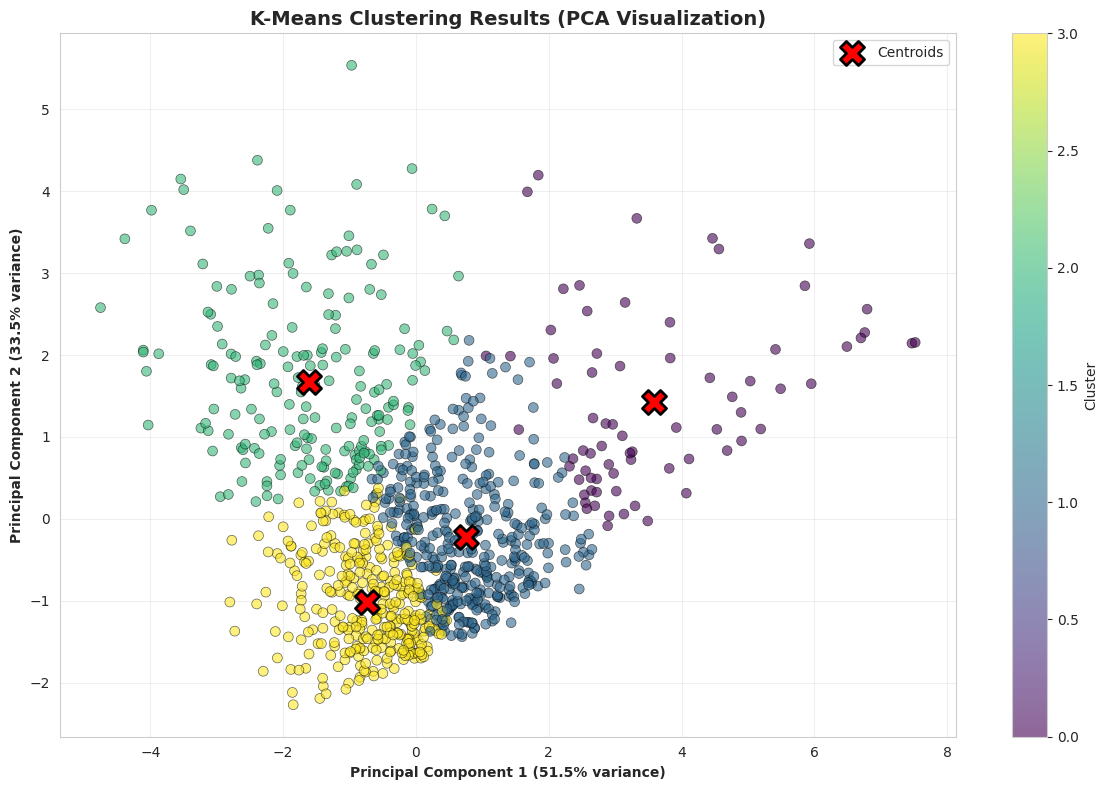

In [35]:
# 8. CLUSTER VISUALIZATION (PCA)
print("\n[STEP 7] Visualizing Clusters using PCA...")

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"✓ PCA completed")
print(f"  PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% variance")
print(f"  PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% variance")
print(f"  Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# Visualize K-Means clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['cluster_kmeans'],
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot cluster centers (transform to PCA space)
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centroids')

plt.title('K-Means Clustering Results (PCA Visualization)', fontweight='bold', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/06_cluster_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 06_cluster_visualization.png")


[STEP 8] Cluster Profiling and Interpretation...

Cluster Profiles (K-Means):
                trip_frequency  avg_booking_value  destination_diversity  \
cluster_kmeans                                                             
0                         3.49            2897.19                   2.21   
1                         3.11             941.83                   2.18   
2                         8.39             776.70                   5.85   
3                         3.06             495.17                   1.79   

                session_duration_mins  searches_per_session  
cluster_kmeans                                               
0                               22.58                 19.59  
1                               17.44                 12.75  
2                               12.80                  9.21  
3                               13.01                  8.10  
✓ Saved: 07_cluster_profiles.png


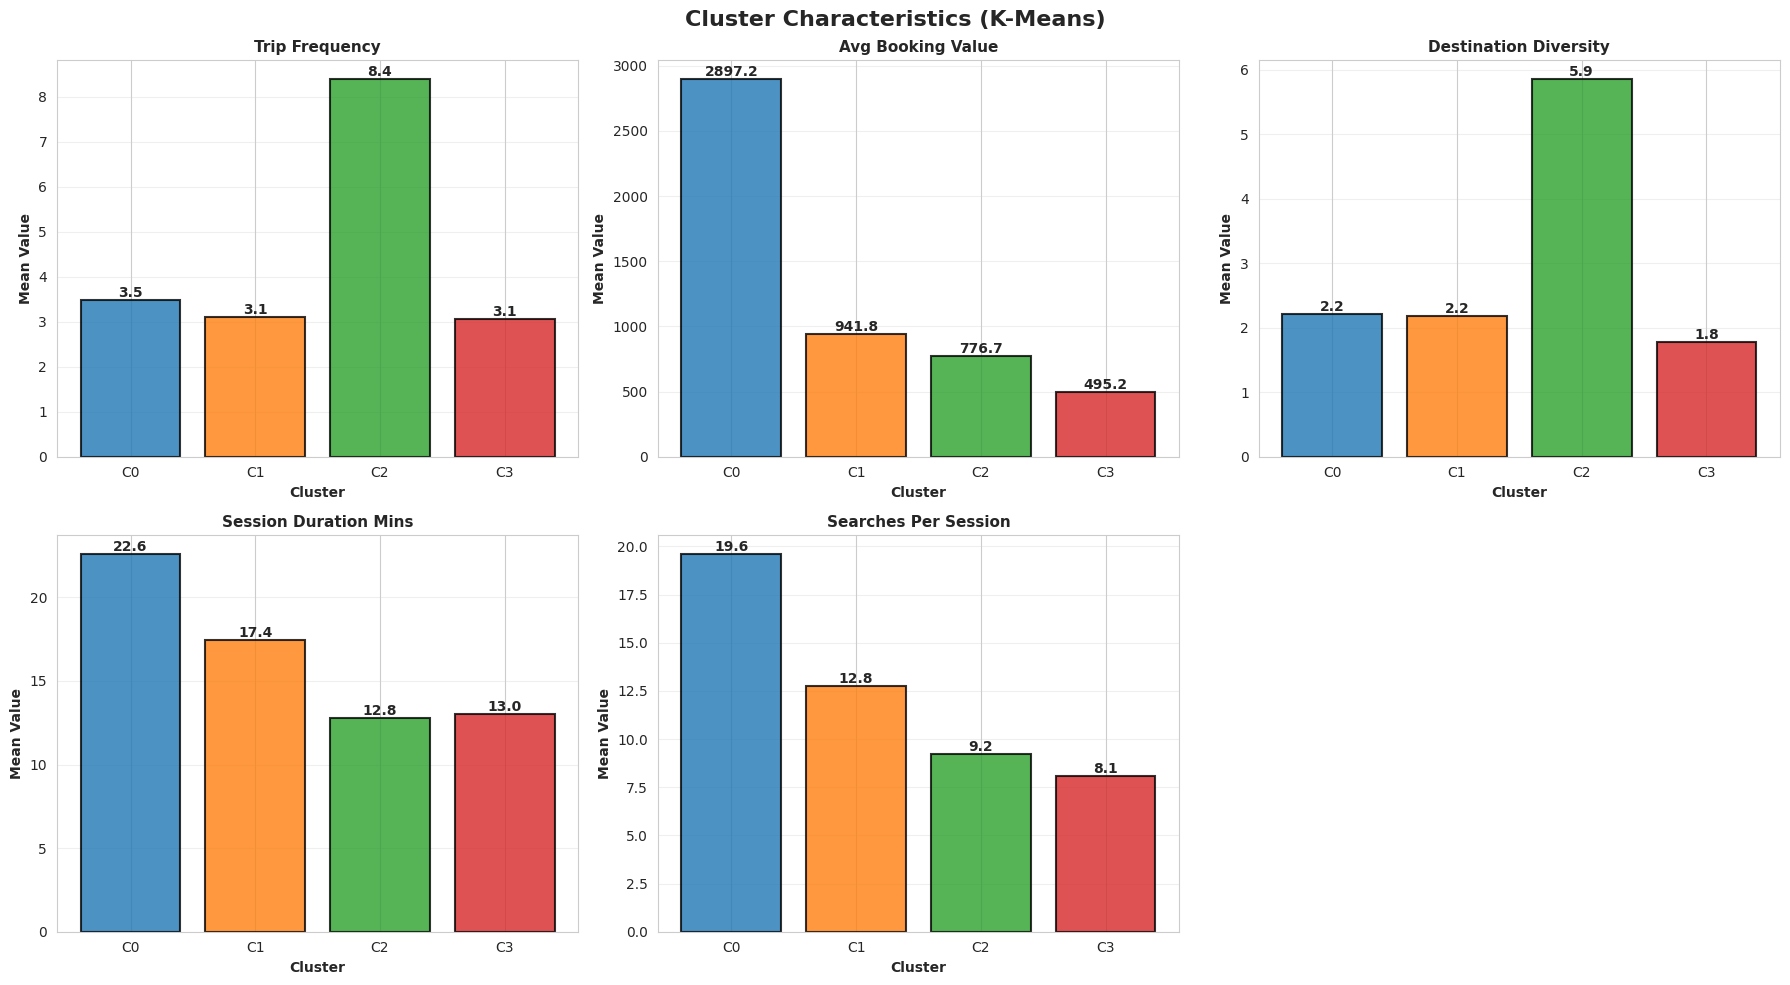

In [36]:
# 9. CLUSTER PROFILING AND INTERPRETATION
print("\n[STEP 8] Cluster Profiling and Interpretation...")

# Analyze K-Means clusters (best performing)
cluster_profiles = df_clean.groupby('cluster_kmeans')[features].mean()

print("\nCluster Profiles (K-Means):")
print("="*80)
print(cluster_profiles.round(2))

# Visualize cluster profiles
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Cluster Characteristics (K-Means)', fontsize=16, fontweight='bold')

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3

    cluster_means = df_clean.groupby('cluster_kmeans')[feature].mean()

    bars = axes[row, col].bar(range(optimal_k), cluster_means.values,
                               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:optimal_k],
                               edgecolor='black', linewidth=1.5, alpha=0.8)

    axes[row, col].set_title(feature.replace('_', ' ').title(), fontweight='bold', fontsize=11)
    axes[row, col].set_xlabel('Cluster', fontweight='bold')
    axes[row, col].set_ylabel('Mean Value', fontweight='bold')
    axes[row, col].set_xticks(range(optimal_k))
    axes[row, col].set_xticklabels([f'C{i}' for i in range(optimal_k)])
    axes[row, col].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/07_cluster_profiles.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 07_cluster_profiles.png")

In [37]:
# 10. BUSINESS INSIGHTS AND SEGMENT NAMING
print("\n[STEP 9] Analyzing Discovered Segments and Business Interpretation...")

# Analyze each cluster to understand what K-Means discovered
# NOTE: We name segments AFTER seeing the cluster characteristics
# The algorithm discovered these patterns - we're just interpreting them

segment_names = {}
segment_insights = {}

print("\n" + "="*80)
print("DISCOVERED CLUSTER CHARACTERISTICS")
print("="*80)

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster_kmeans'] == cluster]

    avg_freq = cluster_data['trip_frequency'].mean()
    avg_value = cluster_data['avg_booking_value'].mean()
    avg_diversity = cluster_data['destination_diversity'].mean()
    avg_session = cluster_data['session_duration_mins'].mean()
    avg_searches = cluster_data['searches_per_session'].mean()

    print(f"\nCluster {cluster} Raw Statistics:")
    print(f"  Trip Frequency: {avg_freq:.2f}")
    print(f"  Booking Value: ${avg_value:.2f}")
    print(f"  Destination Diversity: {avg_diversity:.2f}")
    print(f"  Session Duration: {avg_session:.2f} min")
    print(f"  Searches/Session: {avg_searches:.2f}")

    # NOW we interpret and name based on discovered characteristics
    if avg_value > 2000:
        segment_names[cluster] = "Luxury Travellers"
        insight = "High-value customers seeking premium experiences. Target with exclusive packages and personalized concierge services."
    elif avg_freq > 8:
        segment_names[cluster] = "Business Travellers"
        insight = "Frequent travellers with moderate budgets. Focus on loyalty programs, quick booking, and business-class upgrades."
    elif avg_searches > 15:
        segment_names[cluster] = "Family/Group Planners"
        insight = "Thorough planners with moderate budgets. Provide detailed information, family packages, and flexible options."
    else:
        segment_names[cluster] = "Budget Explorers"
        insight = "Cost-conscious occasional travellers. Emphasize deals, discounts, and value-for-money destinations."

    segment_insights[cluster] = insight

    print(f"  → Interpreted as: {segment_names[cluster]}")
    print(f"  → Strategy: {insight}")

print("\n" + "="*80)
print("IMPORTANT: These segment names are our INTERPRETATION of patterns")
print("discovered by K-Means. The algorithm found 4 natural groupings based")
print("on feature similarities - we're labeling them for business use.")
print("="*80)

# Add segment names to dataframe
df_clean['segment_name'] = df_clean['cluster_kmeans'].map(segment_names)


[STEP 9] Analyzing Discovered Segments and Business Interpretation...

DISCOVERED CLUSTER CHARACTERISTICS

Cluster 0 Raw Statistics:
  Trip Frequency: 3.49
  Booking Value: $2897.19
  Destination Diversity: 2.21
  Session Duration: 22.58 min
  Searches/Session: 19.59
  → Interpreted as: Luxury Travellers
  → Strategy: High-value customers seeking premium experiences. Target with exclusive packages and personalized concierge services.

Cluster 1 Raw Statistics:
  Trip Frequency: 3.11
  Booking Value: $941.83
  Destination Diversity: 2.18
  Session Duration: 17.44 min
  Searches/Session: 12.75
  → Interpreted as: Budget Explorers
  → Strategy: Cost-conscious occasional travellers. Emphasize deals, discounts, and value-for-money destinations.

Cluster 2 Raw Statistics:
  Trip Frequency: 8.39
  Booking Value: $776.70
  Destination Diversity: 5.85
  Session Duration: 12.80 min
  Searches/Session: 9.21
  → Interpreted as: Business Travellers
  → Strategy: Frequent travellers with moderate b


[STEP 10] Creating Final Visualizations...
✓ Saved: 08_segment_distribution.png
✓ Saved: 09_segment_comparison.png


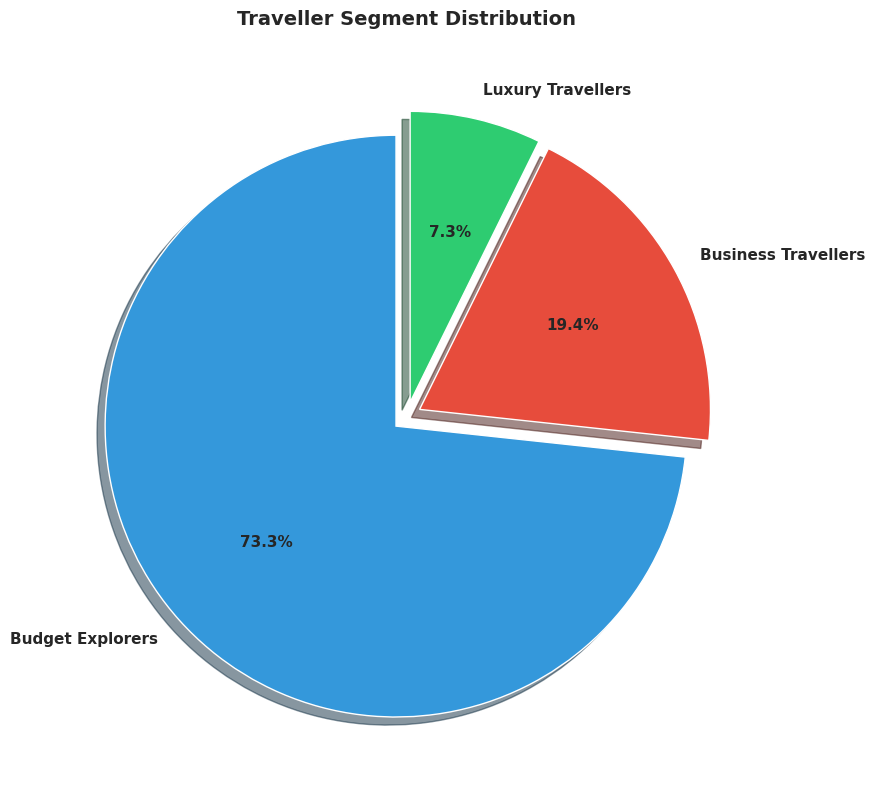

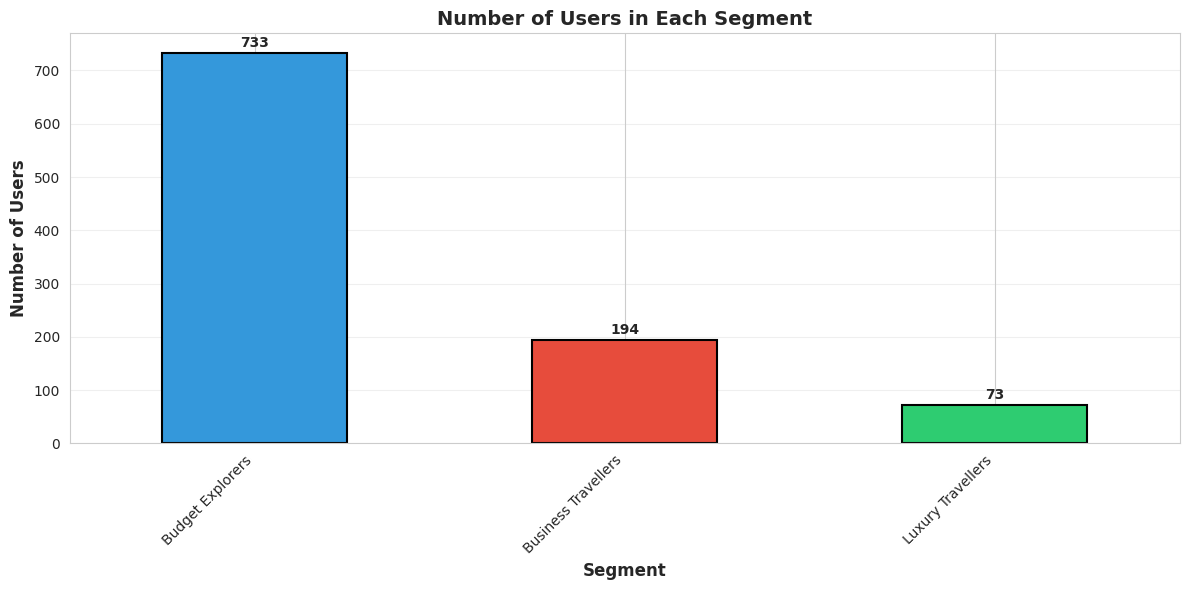

In [38]:
# 11. FINAL VISUALIZATIONS
print("\n[STEP 10] Creating Final Visualizations...")

# Segment distribution pie chart
plt.figure(figsize=(10, 8))
segment_counts = df_clean['segment_name'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(segment_counts)]
explode = [0.05] * len(segment_counts)

plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, shadow=True,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Traveller Segment Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/08_segment_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 08_segment_distribution.png")

# Bar chart comparison for easier understanding
fig, ax = plt.subplots(figsize=(12, 6))
segment_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5, ax=ax)
ax.set_title('Number of Users in Each Segment', fontsize=14, fontweight='bold')
ax.set_xlabel('Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(segment_counts.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/09_segment_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 09_segment_comparison.png")

In [39]:
# 12. SAVE RESULTS
print("\n[STEP 11] Saving Results...")

import os

# Create the output directory if it doesn't exist
output_dir = '/mnt/user-data/outputs'
os.makedirs(output_dir, exist_ok=True)

# Save clustered dataset
output_file = os.path.join(output_dir, 'clustered_travellers.csv')
df_clean.to_csv(output_file, index=False)
print(f"✓ Saved: clustered_travellers.csv")

# Create summary report
summary_report = []
summary_report.append("="*80)
summary_report.append("VOYAGE AI - TRAVEL ANALYTICS CLUSTERING PROJECT")
summary_report.append("EXECUTIVE SUMMARY")
summary_report.append("="*80)
summary_report.append(f"\nTotal Users Analyzed: {len(df_clean)}")
summary_report.append(f"Number of Segments Identified: {optimal_k}")
summary_report.append(f"\nClustering Algorithm: K-Means")
summary_report.append(f"  Silhouette Score: {silhouette_kmeans:.4f}")
summary_report.append("\n" + "="*80)
summary_report.append("SEGMENT PROFILES")
summary_report.append("="*80)

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster_kmeans'] == cluster]
    summary_report.append(f"\n{segment_names[cluster]} (Cluster {cluster})")
    summary_report.append("-" * 80)
    summary_report.append(f"  Size: {len(cluster_data)} users ({len(cluster_data)/len(df_clean)*100:.1f}%)")
    summary_report.append(f"  Avg Trip Frequency: {cluster_data['trip_frequency'].mean():.2f}")
    summary_report.append(f"  Avg Booking Value: ${cluster_data['avg_booking_value'].mean():.2f}")
    summary_report.append(f"  Avg Destination Diversity: {cluster_data['destination_diversity'].mean():.2f}")
    summary_report.append(f"  Avg Session Duration: {cluster_data['session_duration_mins'].mean():.2f} min")
    summary_report.append(f"  Avg Searches/Session: {cluster_data['searches_per_session'].mean():.2f}")
    summary_report.append(f"\n  Strategy: {segment_insights[cluster]}")

specified_k = optimal_k
summary_report.append("\n" + "="*80)
summary_report.append("KEY RECOMMENDATIONS")
summary_report.append("="*80)
summary_report.append("\n1. Personalization Strategy:")
summary_report.append("   - Customize website experience for each segment")
summary_report.append("   - Send targeted email campaigns")
summary_report.append("\n2. Marketing Optimization:")
summary_report.append("   - Focus marketing budget on high-value segments")
summary_report.append("   - Create segment-specific promotions")
summary_report.append("\n3. Product Development:")
summary_report.append("   - Develop premium features for Luxury Travellers")
summary_report.append("   - Streamline booking for Business Travellers")
summary_report.append("   - Provide comparison tools for Family Planners")
summary_report.append("   - Highlight deals for Budget Explorers")
summary_report.append("\n" + "="*80)

# Save summary report
report_file = os.path.join(output_dir, 'project_summary.txt')
with open(report_file, 'w') as f:
    f.write('\n'.join(summary_report))
print(f"✓ Saved: project_summary.txt")


[STEP 11] Saving Results...
✓ Saved: clustered_travellers.csv
✓ Saved: project_summary.txt


In [40]:
# FINAL OUTPUT
print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated Files:")
print("  1. 01_feature_distributions.png - Data exploration")
print("  2. 02_correlation_matrix.png - Feature relationships")
print("  3. 03_feature_scaling.png - Before/after scaling")
print("  4. 04_elbow_method.png - Finding optimal clusters")
print("  5. 05_silhouette_analysis.png - Cluster quality")
print("  6. 06_cluster_visualization.png - Visual clusters (PCA)")
print("  7. 07_cluster_profiles.png - Segment characteristics")
print("  8. 08_segment_distribution.png - Segment sizes")
print("  9. 09_segment_comparison.png - Bar chart comparison")
print("  10. clustered_travellers.csv - Dataset with clusters")
print("  11. project_summary.txt - Business insights")
print("\n" + "="*80)


PROJECT COMPLETED SUCCESSFULLY!

Generated Files:
  1. 01_feature_distributions.png - Data exploration
  2. 02_correlation_matrix.png - Feature relationships
  3. 03_feature_scaling.png - Before/after scaling
  4. 04_elbow_method.png - Finding optimal clusters
  5. 05_silhouette_analysis.png - Cluster quality
  6. 06_cluster_visualization.png - Visual clusters (PCA)
  7. 07_cluster_profiles.png - Segment characteristics
  8. 08_segment_distribution.png - Segment sizes
  9. 09_segment_comparison.png - Bar chart comparison
  10. clustered_travellers.csv - Dataset with clusters
  11. project_summary.txt - Business insights



In [41]:
# Close all figures
plt.close('all')

print("\n✓ All visualizations saved!")


✓ All visualizations saved!
